# OpenAI Function Calling In LangChain

In [1]:
from typing import List
from pydantic import BaseModel, Field

## Pydantic Syntax

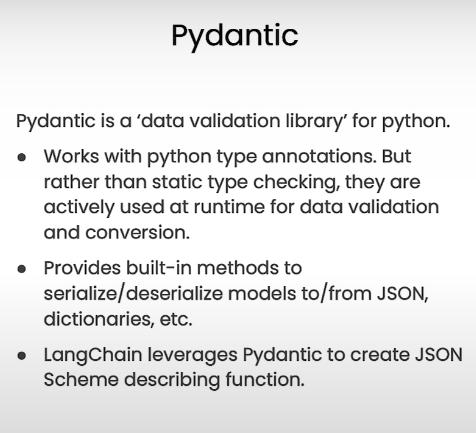

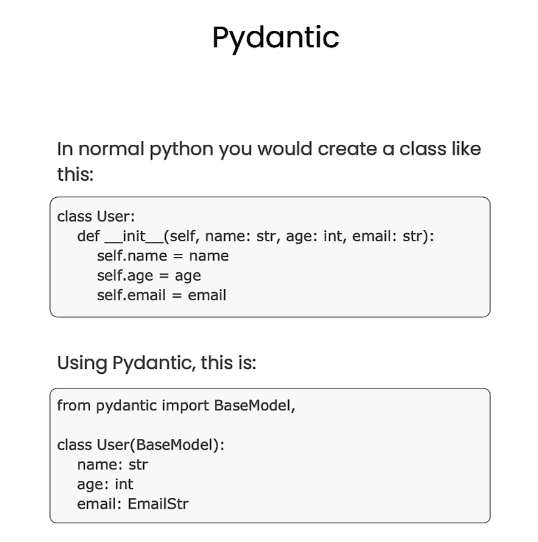

Pydantic data classes are a blend of Python's data classes with the validation power of Pydantic. 

They offer a concise way to define data structures while ensuring that the data adheres to specified types and constraints.

In standard python you would create a class like this:

In [2]:
class User:
    def __init__(self, name: str, age: int, email: str):
        self.name = name
        self.age = age
        self.email = email

In [3]:
foo = User(name="Joe",age=32, email="joe@gmail.com")

In [4]:
foo.name

'Joe'

In [5]:
foo = User(name="Joe",age="bar", email="joe@gmail.com")

In [6]:
foo.age

'bar'

In [7]:
class pUser(BaseModel):
    name: str
    age: int
    email: str

In [8]:
foo_p = pUser(name="Jane", age=32, email="jane@gmail.com")

In [50]:
foo_p

pUser(name='Jane', age=32, email='jane@gmail.com')

In [9]:
foo_p.name

'Jane'

**Note**: The next cell is expected to fail.

In [10]:
foo_p = pUser(name="Jane", age="bar", email="jane@gmail.com")

ValidationError: 1 validation error for pUser
age
  value is not a valid integer (type=type_error.integer)

# Nested Pydantic Models

In [11]:
class Class(BaseModel):
    students: List[pUser]

In [12]:
obj = Class(
    students=[pUser(name="Jane", age=32, email="jane@gmail.com")]
)

In [13]:
obj

Class(students=[pUser(name='Jane', age=32, email='jane@gmail.com')])

## Pydantic to OpenAI function definition


In [14]:
class WeatherSearch(BaseModel):
    """Call this with an airport code to get the weather at that airport"""
    airport_code: str = Field(description="airport code to get weather for")

In [24]:
from langchain_core.utils.function_calling import convert_to_openai_function

In [25]:
weather_function = convert_to_openai_function(WeatherSearch)

In [26]:
weather_function

{'name': 'WeatherSearch',
 'description': 'Call this with an airport code to get the weather at that airport',
 'parameters': {'type': 'object',
  'properties': {'airport_code': {'description': 'airport code to get weather for',
    'type': 'string'}},
  'required': ['airport_code']}}

In [27]:
# Remove docstring which means the description ""
class WeatherSearch1(BaseModel):
    airport_code: str = Field(description="airport code to get weather for")

In [29]:
convert_to_openai_function(WeatherSearch1)

{'name': 'WeatherSearch1',
 'description': '',
 'parameters': {'type': 'object',
  'properties': {'airport_code': {'description': 'airport code to get weather for',
    'type': 'string'}},
  'required': ['airport_code']}}

In [30]:
# Remove Field description which means properties do not have descriptions attribute
class WeatherSearch2(BaseModel):
    """Call this with an airport code to get the weather at that airport"""
    airport_code: str

In [31]:
convert_to_openai_function(WeatherSearch2)

{'name': 'WeatherSearch2',
 'description': 'Call this with an airport code to get the weather at that airport',
 'parameters': {'type': 'object',
  'properties': {'airport_code': {'type': 'string'}},
  'required': ['airport_code']}}

In [32]:
from langchain_openai import ChatOpenAI

In [33]:
model = ChatOpenAI()

In [34]:
model.invoke("what is the weather in SF today?", functions=[weather_function])

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"airport_code":"SFO"}', 'name': 'WeatherSearch'}}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 70, 'total_tokens': 87}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-5d5ee1a4-143c-4d16-9136-8260fed5842d-0', usage_metadata={'input_tokens': 70, 'output_tokens': 17, 'total_tokens': 87})

In [35]:
# bind the function to the model so we don't have to pass it in every time when we invoke
model_with_function = model.bind(functions=[weather_function])

In [36]:
model_with_function.invoke("what is the weather in sf?")

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"airport_code":"SFO"}', 'name': 'WeatherSearch'}}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 69, 'total_tokens': 86}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-ff6ca221-5e50-4f8a-a40c-714ba0754e1b-0', usage_metadata={'input_tokens': 69, 'output_tokens': 17, 'total_tokens': 86})

## Forcing it to use a function

We can force the model to use a function

In [37]:
model_with_forced_function = model.bind(functions=[weather_function], function_call={"name":"WeatherSearch"})

In [38]:
model_with_forced_function.invoke("what is the weather in sf?")

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"airport_code":"SFO"}', 'name': 'WeatherSearch'}}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 79, 'total_tokens': 86}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-367b8c82-0049-471d-a0d2-b3a008fa66cf-0', usage_metadata={'input_tokens': 79, 'output_tokens': 7, 'total_tokens': 86})

In [51]:
model_with_function.invoke("hi!")

AIMessage(content='Hello! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 64, 'total_tokens': 74}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-e0879ce2-3086-4a79-8643-d92b59dfc5cb-0', usage_metadata={'input_tokens': 64, 'output_tokens': 10, 'total_tokens': 74})

In [39]:
model_with_forced_function.invoke("hi!")

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"airport_code":"JFK"}', 'name': 'WeatherSearch'}}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 74, 'total_tokens': 81}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-b5aec7aa-7e37-40d2-b5ba-dee417cbfeb8-0', usage_metadata={'input_tokens': 74, 'output_tokens': 7, 'total_tokens': 81})

## Using in a chain

We can use this model bound to function in a chain as we normally would

In [40]:
from langchain_core.prompts import ChatPromptTemplate

In [41]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant"),
    ("user", "{input}")
])

In [42]:
chain = prompt | model_with_function

In [43]:
chain.invoke({"input": "what is the weather in sf?"})

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"airport_code":"SFO"}', 'name': 'WeatherSearch'}}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 75, 'total_tokens': 92}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-18d4ad55-dacc-4f92-97c5-c7364f57d06b-0', usage_metadata={'input_tokens': 75, 'output_tokens': 17, 'total_tokens': 92})

## Using multiple functions

Even better, we can pass a set of function and let the LLM decide which to use based on the question context.

In [44]:
class ArtistSearch(BaseModel):
    """Call this to get the names of songs by a particular artist"""
    artist_name: str = Field(description="name of artist to look up")
    n: int = Field(description="number of results")

In [45]:
functions = [
    convert_to_openai_function(WeatherSearch),
    convert_to_openai_function(ArtistSearch),
]

In [46]:
model_with_functions = model.bind(functions=functions)

In [47]:
model_with_functions.invoke("what is the weather in sf?")

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"airport_code":"SFO"}', 'name': 'WeatherSearch'}}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 116, 'total_tokens': 133}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-ffc938ce-8bd6-4589-b090-767066a99364-0', usage_metadata={'input_tokens': 116, 'output_tokens': 17, 'total_tokens': 133})

In [48]:
model_with_functions.invoke("what are three songs by taylor swift?")

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"artist_name":"Taylor Swift","n":3}', 'name': 'ArtistSearch'}}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 118, 'total_tokens': 139}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-176f94d5-a4f0-4fae-beb7-95edbc3ef076-0', usage_metadata={'input_tokens': 118, 'output_tokens': 21, 'total_tokens': 139})

In [52]:
model_with_functions.invoke("what are the top 5 songs by sam smith?")

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"artist_name":"Sam Smith","n":5}', 'name': 'ArtistSearch'}}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 120, 'total_tokens': 141}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-6f893906-9317-4d69-ad8d-5e1e85590c50-0', usage_metadata={'input_tokens': 120, 'output_tokens': 21, 'total_tokens': 141})

In [49]:
model_with_functions.invoke("hi!")

AIMessage(content='Hello! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 111, 'total_tokens': 121}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-e5baf8b7-7bc4-4713-93c0-cc46cea4d79f-0', usage_metadata={'input_tokens': 111, 'output_tokens': 10, 'total_tokens': 121})